In [42]:
import numpy as np

from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.utils import check_random_state
plt.rcParams['image.cmap'] = 'gray'

In [43]:
from emnist import list_datasets
from emnist import extract_training_samples
X_train, Y_train = extract_training_samples('mnist')

In [44]:
from emnist import extract_test_samples
X_test, Y_test = extract_test_samples('mnist')

In [45]:
X_train=X_train.reshape(60000, 784)
X_test=X_test.reshape(10000, 784)


X_train = minmax_scale(X_train, feature_range=(0, 1))  # 0-1 scaling
X_test = minmax_scale(X_test, feature_range=(0, 1))  # 0-1 scaling

In [46]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

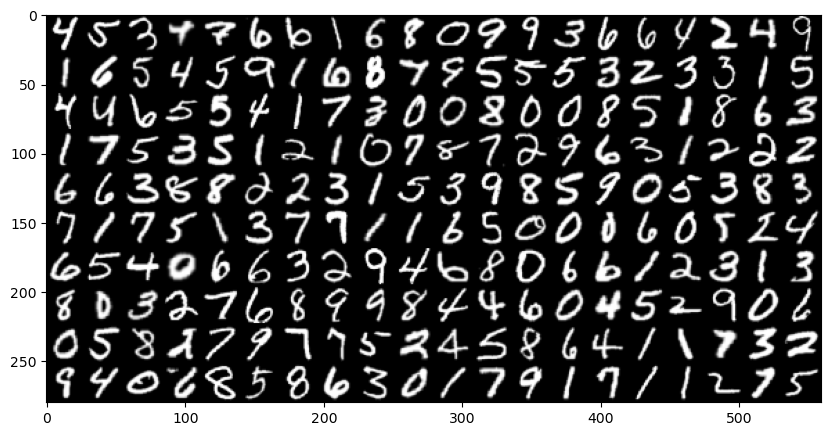

In [47]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train))

## Models definition

We build a classification pipeline with a BernoulliRBM feature extractor and
a :class:`LogisticRegression <sklearn.linear_model.LogisticRegression>`
classifier.




In [48]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

The hyperparameters of the entire model (learning rate, hidden layer size,
regularization) were optimized by grid search, but the search is not
reproduced here because of runtime constraints.

In [49]:
from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

1) Fit RBM and train a logistic regression classifier on extracted features, where: 
        extract features $ q_i=p(h|v=x_i) $

2) Train a logistic regression classifier on raw pixels

In [50]:
import random
random.seed(3)
# Training RBM and obtaining the transformed input for Logistic
rbm_fit=rbm.fit(X_train)
Q_train=rbm_fit.transform(X_train)
Q_test=rbm_fit.transform(X_test)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -124.04, time = 29.25s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -117.94, time = 27.50s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -117.56, time = 11.86s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -118.11, time = 11.66s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -118.06, time = 16.06s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -114.98, time = 16.38s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -113.86, time = 15.88s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -114.54, time = 15.48s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -113.62, time = 15.98s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -112.45, time = 19.47s


In [ ]:
# Training Logistic with RBM-tranformed data
logistic_fit=logistic.fit(Q_train, Y_train)


# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

In [ ]:
## Evaluation
from sklearn import metrics

Y_pred_RBM = logistic_fit.predict(Q_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred_RBM))
)
Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.99      0.98      0.99      1000
           2       0.94      0.94      0.94      1000
           3       0.94      0.91      0.92      1000
           4       0.94      0.95      0.95      1000
           5       0.94      0.93      0.93      1000
           6       0.96      0.98      0.97      1000
           7       0.96      0.94      0.95      1000
           8       0.90      0.92      0.91      1000
           9       0.92      0.92      0.92      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1000
           1       0.94      0.97      0.96  

The features extracted by the BernoulliRBM help improve the classification
accuracy with respect to the logistic regression on raw pixels.

plot confusion matrix FOR THE LOGISTIC CLASSIFIER TRAINED ON EXTRACTED FEATURES FROM RBM 

In [ ]:
def plot_confusion_matrix(C, labels=None, labels_fontsize=13, **heatmap_params):
    # default params
    labels = labels or range(C.shape[0])
    annot_fontsize = 14
    xy_label_fontsize = 21

    # set default params where possible
    if not 'annot' in heatmap_params:
        heatmap_params['annot'] = True
    if not 'fmt' in heatmap_params:
        heatmap_params['fmt'] = 'd' if C.dtype is np.dtype('int') else '.3f'
    if not 'annot_kws' in heatmap_params:
        heatmap_params['annot_kws'] = {'size': annot_fontsize}
    elif not 'size' in heatmap_params['annot_kws']:
        heatmap_params['annot_kws']['size'] = annot_fontsize
    if not 'xticklabels' in heatmap_params:
        heatmap_params['xticklabels'] = labels
    if not 'yticklabels' in heatmap_params:
        heatmap_params['yticklabels'] = labels

    # plot the stuff
    with plt.rc_context(rc={'xtick.labelsize': labels_fontsize,
                            'ytick.labelsize': labels_fontsize}):
        ax = sns.heatmap(C, **heatmap_params)
        plt.xlabel('predicted', fontsize=xy_label_fontsize)
        plt.ylabel('actual', fontsize=xy_label_fontsize)
        return ax

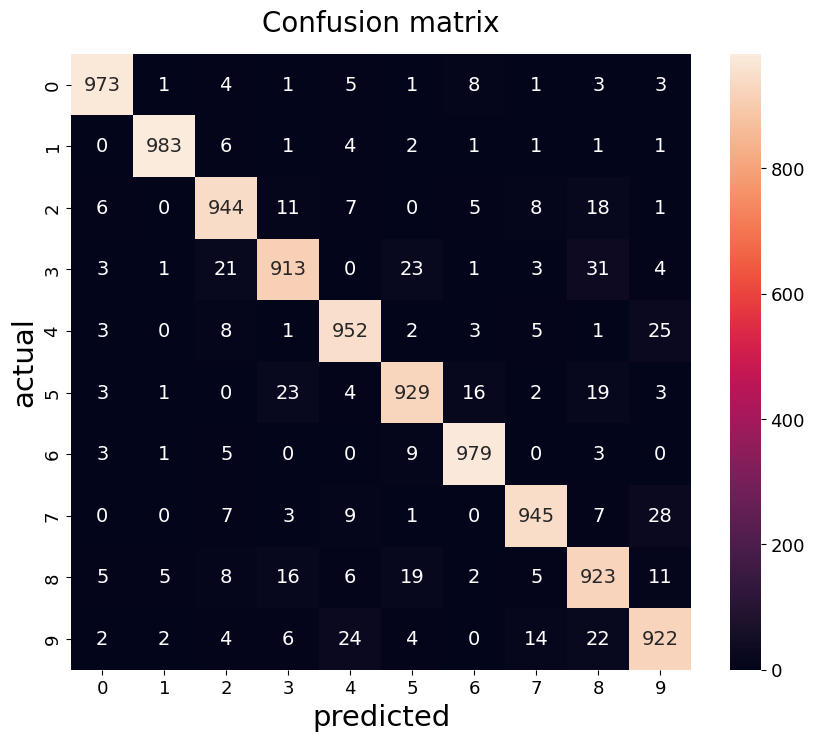

In [ ]:
C = confusion_matrix(Y_test, Y_pred_RBM)

fig = plt.figure(figsize=(10, 8))
ax = plot_confusion_matrix(C, fmt='d')
plt.title('Confusion matrix\n', fontsize=20, y=0.97)
plt.savefig('rbm_mnist_confusion_matrix.png', dpi=144, bbox_inches='tight')

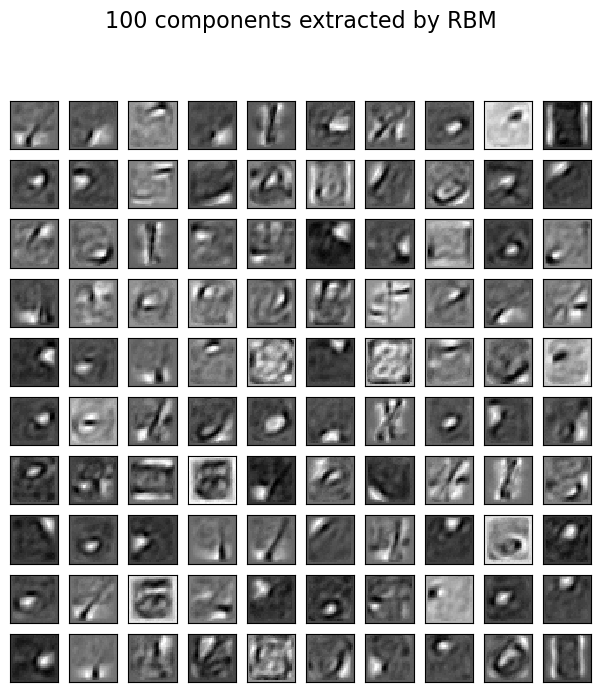

In [51]:
## Plotting

plt.figure(figsize=(7, 7))
for i, comp in enumerate(rbm_fit.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

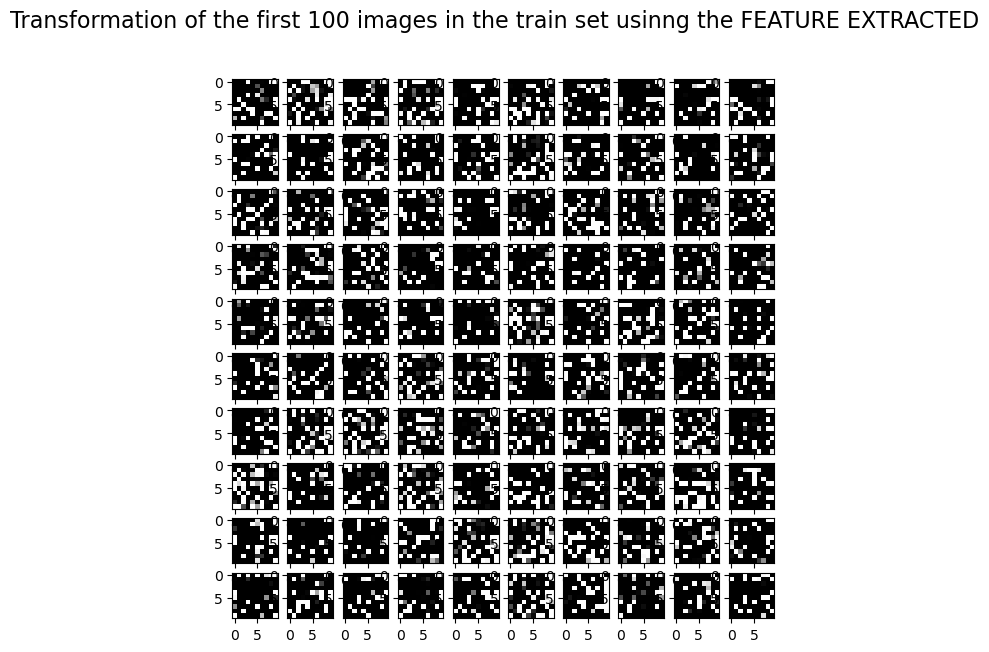

In [52]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(1, -1, 10, 10), 0, 2), 1, 3).reshape(-1, 1 * 10)
Q=rbm_fit.transform(X_train)

'''
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(Q[2:3]))
'''

plt.figure(figsize=(7, 7))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(gen_mnist_image(Q[i:i+1]))
plt.suptitle("Transformation of the first 100 images in the train set usinng the FEATURE EXTRACTED", fontsize=16)


plt.show()

FIT AND TEST KNN AND SVM CLASSIFIERS WITH THE TRANSFORMED IMAGES AND WITH RAW PIXELS

fit k-NN


In [ ]:
knn = KNN(n_neighbors=3, p=2., weights='distance', 
          n_jobs=2)

knn.fit(Q_train, Y_train)
print (accuracy_score(Y_test, knn.predict(Q_test)))

0.9543


In [ ]:
knn = KNN(n_neighbors=3, p=2., weights='distance', 
          n_jobs=2)

knn.fit(X_train, Y_train)
print (accuracy_score(Y_test, knn.predict(X_test)))

0.9758


fit SVM


In [ ]:
svc = SVC(C=1e3, tol=1e-6, 
          verbose=10, random_state=1337)  # displays progress in terminal

svc.fit(Q_train, Y_train)
print (accuracy_score(Y_test, svc.predict(Q_test)))

[LibSVM]0.9712


In [ ]:
svc = SVC(C=1e3, tol=1e-6, 
          verbose=10, random_state=1337)  # displays progress in terminal

svc.fit(X_train, Y_train)
print (accuracy_score(Y_test, svc.predict(X_test)))

[LibSVM]0.9872


In [ ]:
import pandas as pd

# Assuming you have the accuracy scores and modifications for your models
model_names = ['Logistic', 'KNN', 'SVM']
accuracy_scores = [0.94, 0.97, 0.98]
raw_pixel_scores = [0.92, 0.97, 0.99]

# Create a DataFrame for the table data
table_data = {'Model': model_names, 'Accuracy Score with RBM features': accuracy_scores, 'Accuracy Score with raw pixels': raw_pixel_scores}
df = pd.DataFrame(table_data)

# Set the 'Model' column as the index
df.set_index('Model', inplace=True)

# Display the table
print(df)



          Accuracy Score with RBM features  Accuracy Score with raw pixels
Model                                                                     
Logistic                              0.94                            0.92
KNN                                   0.97                            0.97
SVM                                   0.98                            0.99


## Generation and reconstruction

In [53]:
from scipy.special import expit
def our_sample_visible(h, rng):
    p = np.dot(h, rbm.components_)
    p += rbm.intercept_visible_
    expit(p, out=p)
    return (p, rng.uniform(size=p.shape) < p)

In [54]:
def our_gibbs(v):
    if not hasattr(rbm, "random_state_"):
        rbm.random_state_ = check_random_state(rbm.random_state)
    h_ = rbm._sample_hiddens(v, rbm.random_state_)
    p, v_ = our_sample_visible(h_, rbm.random_state_)
    return (p, v_)

In [ ]:
xx = X_train[:20].copy()
for n in range(20):
    xx[n]= np.random.binomial(1,0.5, size=784)

In [ ]:
for ii in range(10000):
    for i in range(20):
        xx[i] = rbm.gibbs(xx[i])

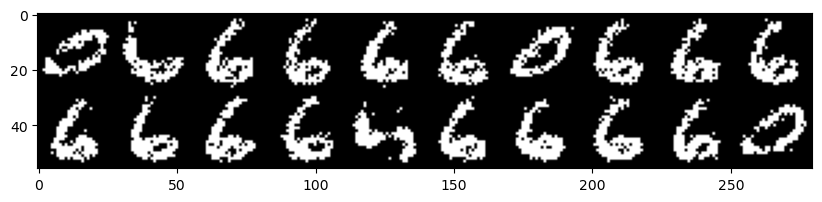

In [ ]:
def gen_mnist_image2(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(10, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 10 * 28)
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image2(xx))

**Generation**

In [55]:
xx = X_train[:20].copy()
p = X_train[:20].copy()
for n in range(20):
    xx[n]= np.random.binomial(1,0.5, size=784)

In [56]:
for ii in range(10000):
    for i in range(20):
        p[i], xx[i] = our_gibbs(xx[i])

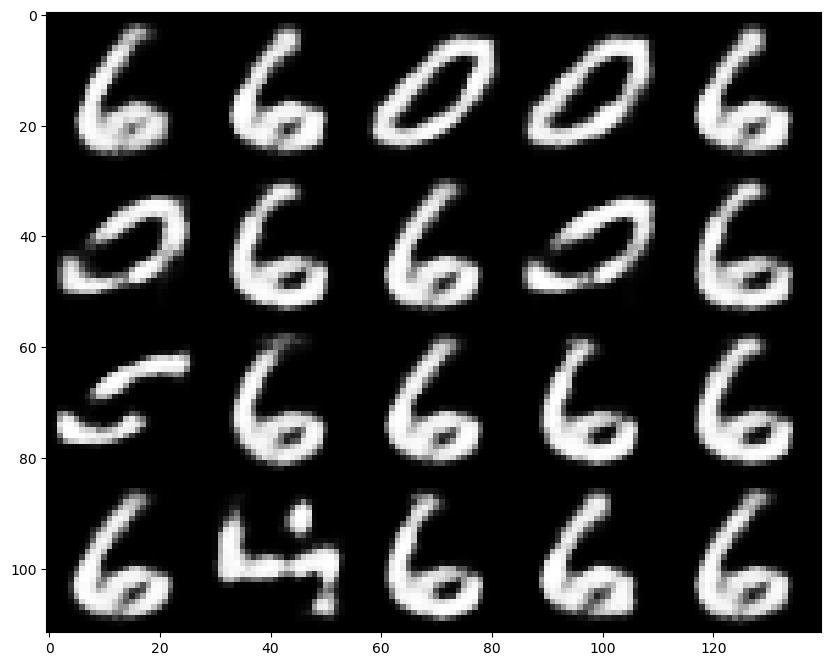

In [57]:
def gen_mnist_image20(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(5, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 5 * 28)
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image20(p))

Now let's try to see the reconstruction error for each digit in the dataset

First, separate different digits in different vectors

In [58]:
digit0 = []
digit1 = []
digit2 = []
digit3 = []
digit4 = []
digit5 = []
digit6 = []
digit7 = []
digit8 = []
digit9 = []

In [59]:
for i in range(Y_test.shape[0]):
    if Y_test[i] == 0:
        digit0.append(X_test[i])
    if Y_test[i] == 1:
        digit1.append(X_test[i]) 
    if Y_test[i] == 2:
        digit2.append(X_test[i]) 
    if Y_test[i] == 3:
        digit3.append(X_test[i]) 
    if Y_test[i] == 4:
        digit4.append(X_test[i]) 
    if Y_test[i] == 5:
        digit5.append(X_test[i]) 
    if Y_test[i] == 6:
        digit6.append(X_test[i]) 
    if Y_test[i] == 7:
        digit7.append(X_test[i]) 
    if Y_test[i] == 8:
        digit8.append(X_test[i]) 
    if Y_test[i] == 9:
        digit9.append(X_test[i])

In [60]:
digits = np.array((np.array(digit0), np.array(digit1), np.array(digit2), np.array(digit3),np.array(digit4),np.array(digit5),
np.array(digit6),np.array(digit7),np.array(digit8),np.array(digit9)))
print(digits.shape)

(10, 1000, 784)


In [61]:
reconstructed_imgs = np.zeros((10,1000,784))
reconstruction_err = np.zeros((10,1000))
mean_err = np.zeros(10)
std_err = np.zeros(10)
for j in range(10):
    curr_digit = digits[j]
    for i in range(1000):
        reconstructed_imgs[j][i], _ = our_gibbs(curr_digit[i])
        reconstruction_err[j][i] = np.sum(np.abs(reconstructed_imgs[j][i] - curr_digit[i])**2)/784
    mean_err[j] = np.sum(reconstruction_err[j])/1000
    std_err[j] = np.std(reconstruction_err[j])
    print("Mean square error for digit ", j, ": ",mean_err[j], "| Standard deviation for digit ", j, ": ",std_err[j])

Mean square error for digit  0 :  0.023127706186074317 | Standard deviation for digit  0 :  0.008228096915656265
Mean square error for digit  1 :  0.008793589716396084 | Standard deviation for digit  1 :  0.004381991760883561
Mean square error for digit  2 :  0.03102062631851238 | Standard deviation for digit  2 :  0.009753278507624504
Mean square error for digit  3 :  0.026759140030330385 | Standard deviation for digit  3 :  0.009482562857888985
Mean square error for digit  4 :  0.0242054184768473 | Standard deviation for digit  4 :  0.007518018471353043
Mean square error for digit  5 :  0.02755345766068344 | Standard deviation for digit  5 :  0.008973352648929988
Mean square error for digit  6 :  0.025451637910524943 | Standard deviation for digit  6 :  0.00880061239355553
Mean square error for digit  7 :  0.017975087190880732 | Standard deviation for digit  7 :  0.007036620850402585
Mean square error for digit  8 :  0.033135522630961464 | Standard deviation for digit  8 :  0.0101989

In [62]:
print("The mean of the reconstruction error on all the images is:", np.mean(mean_err))

The mean of the reconstruction error on all the images is: 0.024045455731252045


<Figure size 640x480 with 0 Axes>

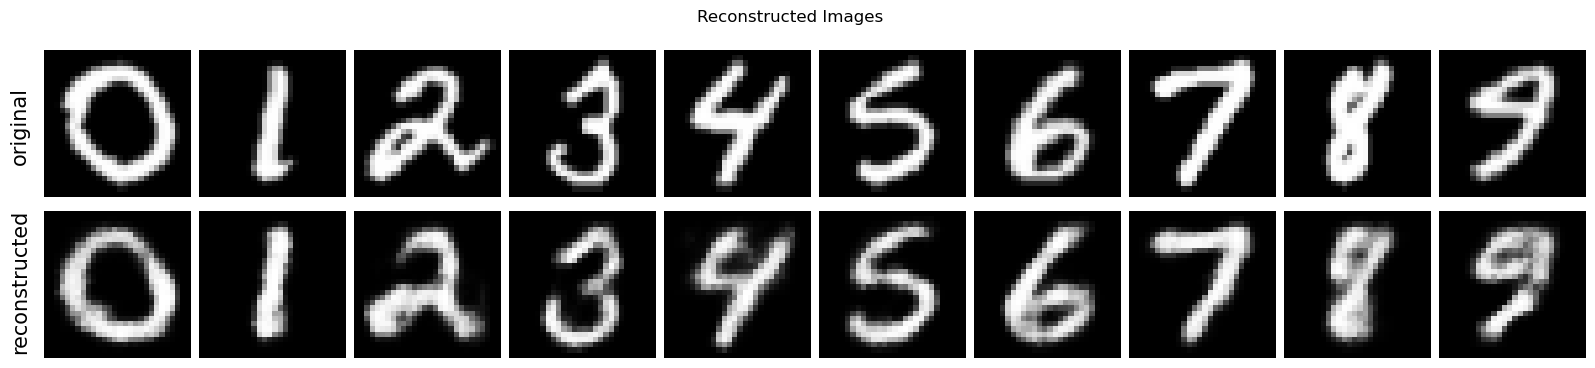

In [63]:
images2 = np.array([digit0[0],digit1[0],digit2[0],digit3[0],digit4[0],digit5[0],digit6[0],digit7[0],digit8[0],digit9[0]])
num_samples = len(images2)
title='Reconstructed Images'
plt.clf()
fig, axes = plt.subplots(2, num_samples, gridspec_kw = {'wspace':0, 'hspace':0.1}, figsize=(num_samples*2, 4))
fig.suptitle(title)
text = axes[0, 0].text(-7, 14,"original", size=15, verticalalignment='center', rotation=-270)
text = axes[1, 0].text(-7, 13,"reconstructed", size=15, verticalalignment='center', rotation=-270)
for n in range(num_samples):
    axes[0, n].imshow(images2[n].reshape(28, 28), cmap='gray')
    axes[1, n].imshow(reconstructed_imgs[n][0].reshape(28, 28), cmap='gray')
    #axes[1, n].imshow(images2[n+10].reshape(28, 28), cmap='gray')
    axes[0, n].axis('off')
    axes[1, n].axis('off')

plt.show()
plt.close()